<a href="https://colab.research.google.com/github/ajit-divakaran/project-share/blob/main/speech_audio_extraction_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np


from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa




In [ ]:
import os
import glob
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def extract_all_features(path, max_length=100):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Feature extraction
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sr)
    mel = librosa.power_to_db(librosa.feature.melspectrogram(y=data, sr=sr), ref=np.max)

    # Combine
    combined = np.vstack([mfcc, chroma, tonnetz, mel]).T  # (timesteps, features)

    # Pad/truncate all to max_length
    def pad_truncate(feat):
        if feat.shape[1] < max_length:
            return np.pad(feat, ((0, 0), (0, max_length - feat.shape[1])), mode='constant')
        else:
            return feat[:, :max_length]

    # Return all properly padded/truncated
    return (
        pad_truncate(mfcc),
        pad_truncate(chroma),
        pad_truncate(tonnetz),
        pad_truncate(mel),
        pad_truncate(combined.T)  # <== CAREFUL here
    )


# 2. Load dataset
dataset_path = "/content/drive/MyDrive/mini dataset/ravedss datset"  # ✅ Make sure path is correct
audio_files = glob.glob(os.path.join(dataset_path, "**/*.wav"), recursive=True)
print(f"Found {len(audio_files)} audio files.")

# 3. Extract features and labels
emotion_map = {
    '01': 0, '02': 1, '03': 2, '04': 3,
    '05': 4, '06': 5, '07': 6, '08': 7
}

X, y = [], []

for file in tqdm(audio_files, desc="Processing files"):
    try:
        emotion_code = os.path.basename(file).split('-')[2]
        mfcc, chroma, tonnetz, mel, combined = extract_all_features(file)
        X.append(combined)  # Only combined is stored for training
        y.append(emotion_map[emotion_code])
    except Exception as e:
        print(f"Skipped {file}: {str(e)}")


X = np.array(X)
y = np.array(y)
print(f"Extracted features: {X.shape}")
print(f"Extracted labels: {y.shape}")

# 4. Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.176, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Found 1440 audio files.


Processing files:  33%|███▎      | 472/1440 [02:54<08:28,  1.90it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=851
  warnings.warn(
Processing files:  50%|█████     | 721/1440 [04:26<03:51,  3.11it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=840
  warnings.warn(
Processing files:  51%|█████     | 733/1440 [04:30<03:46,  3.13it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=805
  warnings.warn(
Processing files:  52%|█████▏    | 747/1440 [04:36<05:03,  2.28it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=828
  warnings.warn(
Processing files:  62%|██████▏   | 893/1440 [05:29<02:53,  3.15it/s]/usr/local/lib/python3.11/dist-packages/

Extracted features: (1440, 159, 100)
Extracted labels: (1440,)
Train: (1008, 159, 100), Validation: (216, 159, 100), Test: (216, 159, 100)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(


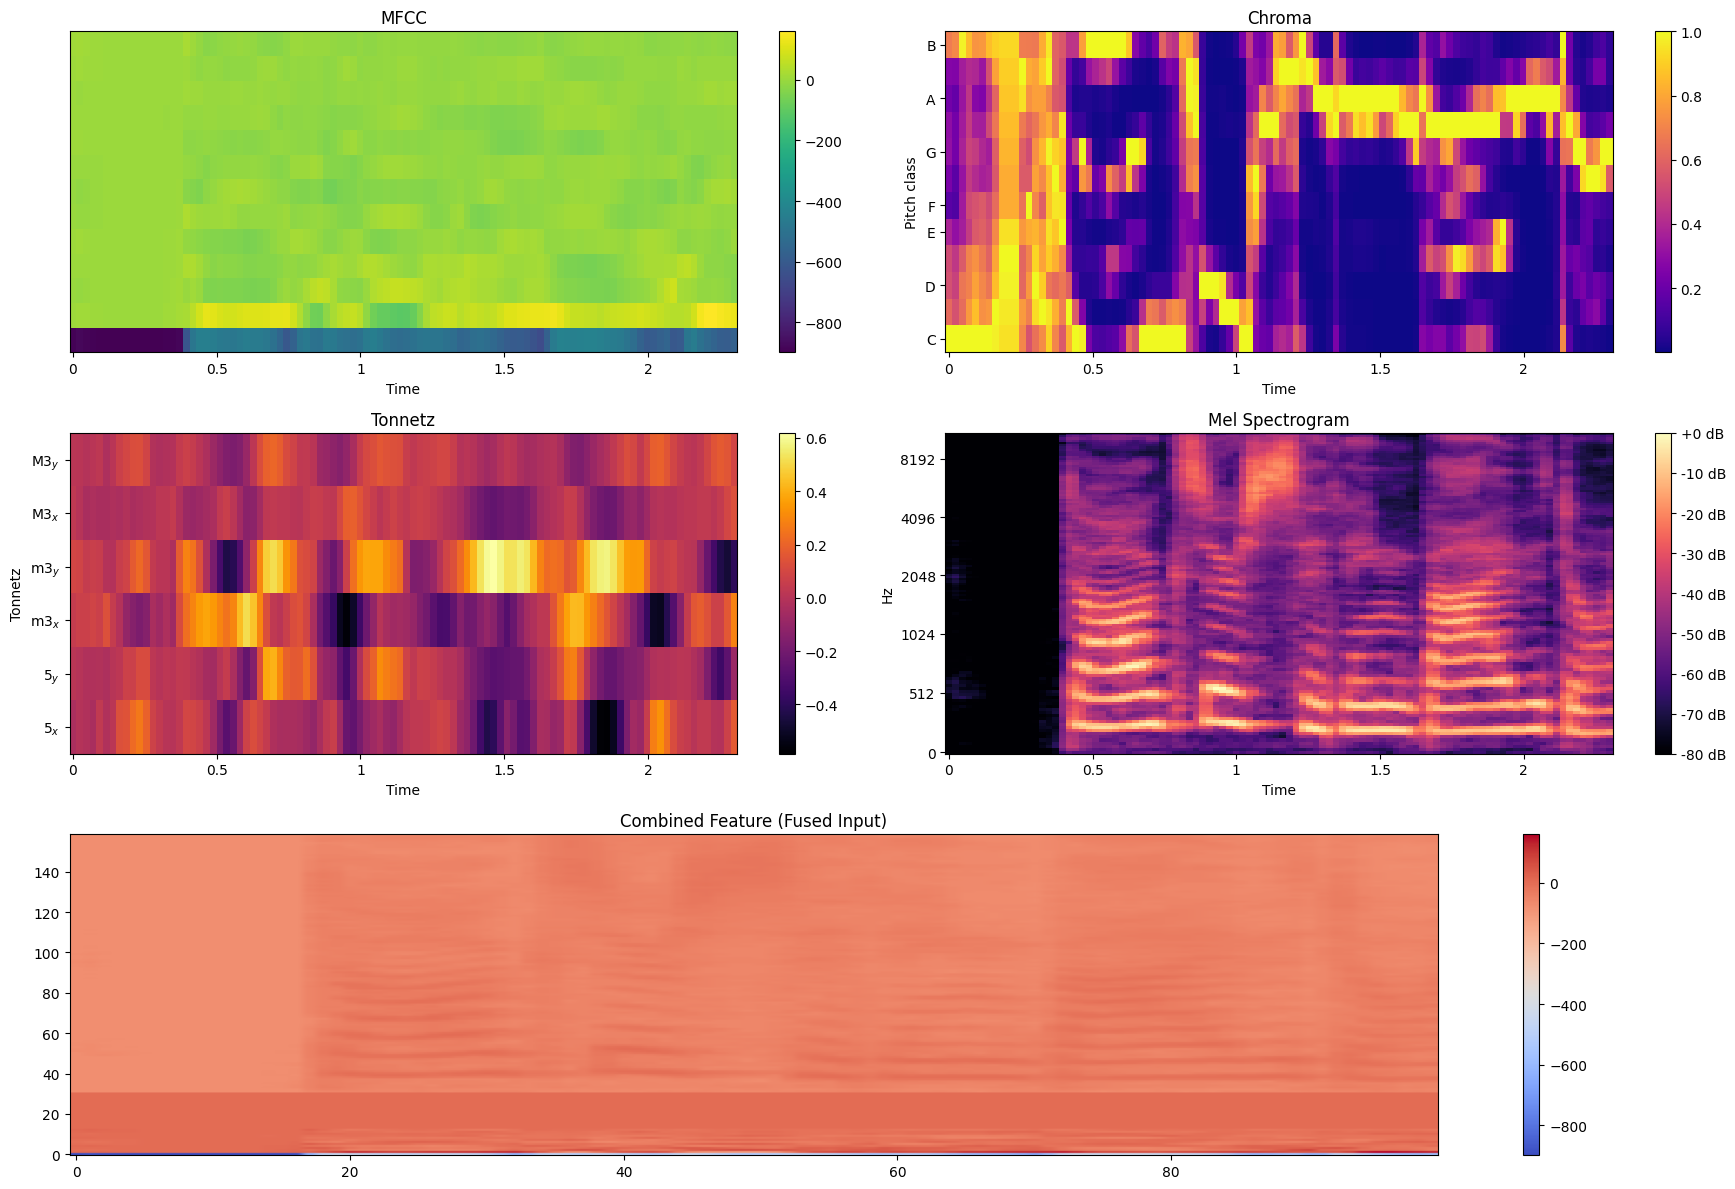

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Select a sample file
sample_file = audio_files[0]  # or pick any other audio file

# Extract features
mfcc, chroma, tonnetz, mel, combined = extract_all_features(sample_file)

# Plot each feature
plt.figure(figsize=(18, 12))

# 1. MFCC
plt.subplot(3, 2, 1)
librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCC')

# 2. Chroma
plt.subplot(3, 2, 2)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='plasma')
plt.colorbar()
plt.title('Chroma')

# 3. Tonnetz
plt.subplot(3, 2, 3)
librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time', cmap='inferno')
plt.colorbar()
plt.title('Tonnetz')

# 4. Mel Spectrogram
plt.subplot(3, 2, 4)
librosa.display.specshow(mel, y_axis='mel', x_axis='time', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# 5. Combined Features
plt.subplot(3, 1, 3)
plt.imshow(combined, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title('Combined Feature (Fused Input)')

plt.tight_layout()
plt.show()
